Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [164]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers.legacy import Adam
#from tensorflow.keras.optimizers import Adam

#Ignore the warnings
import warnings
warnings.filterwarnings('ignore')


In [165]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [224]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
#data_dir_train = pathlib.Path("path_to_train_directory")
data_dir_train = pathlib.Path("C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration\Train")
#data_dir_test = pathlib.Path('path_to_test_directory')
data_dir_test = pathlib.Path('C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration\Test')
data_dir_train_output= pathlib.Path("C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train//output//

In [167]:

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [168]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [169]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# label_mode='categorical',
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, 
                                                               image_size=(img_height,img_width), 
                                                               batch_size=batch_size,
                                                               seed=123,
                                                               subset = 'training', 
                                                               validation_split = 0.20)



Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [172]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
#label_mode='categorical',
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             image_size=(img_height,img_width), 
                                                             batch_size=batch_size, 
                                                             seed=123, 
                                                             subset = 'validation',
                                                             validation_split = 0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [173]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

In [174]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

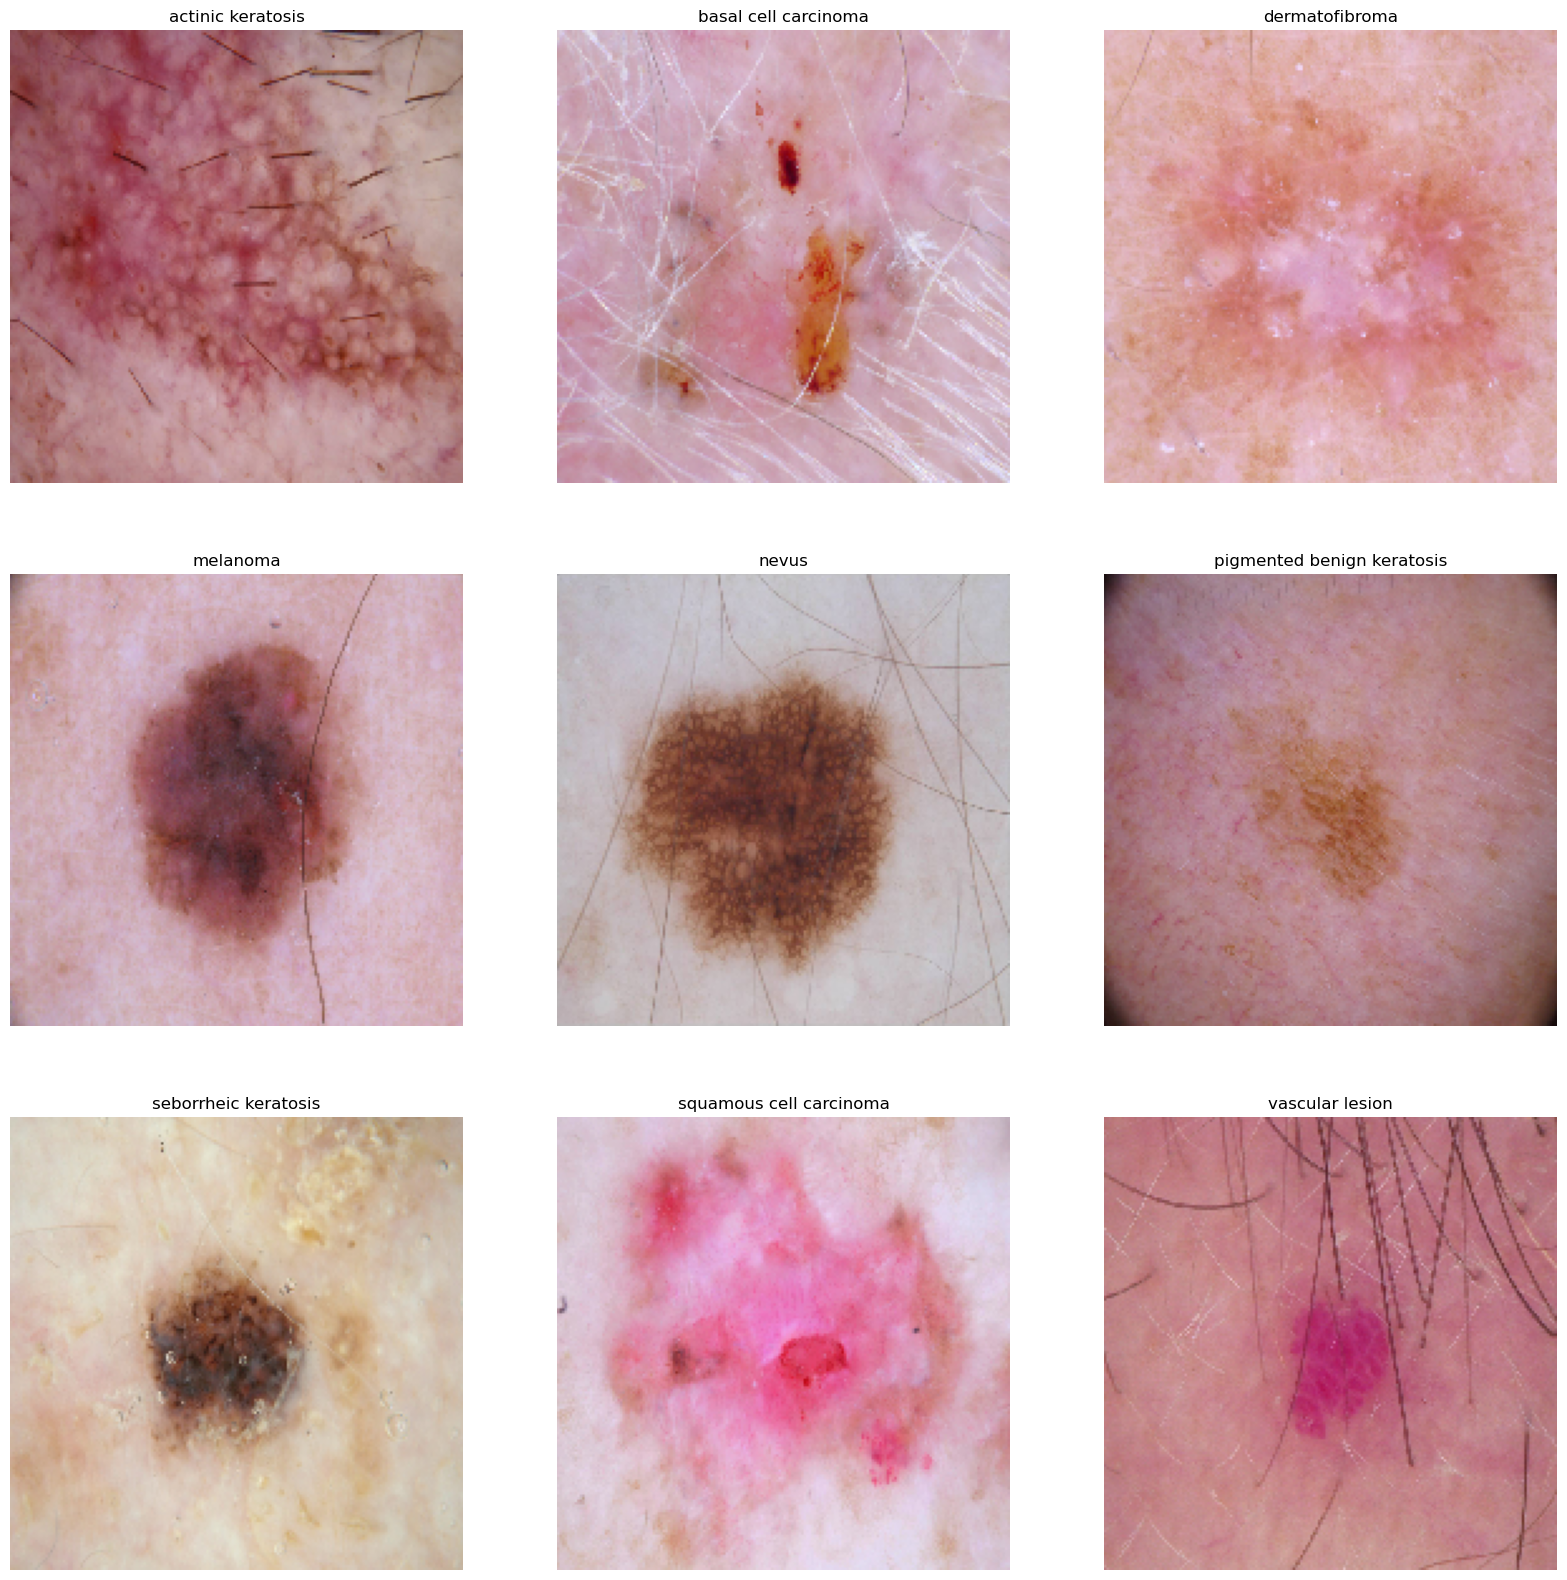

In [175]:
# Creat directionary to store image path per class
dict_file_path = {}

for i in class_names :
  dict_file_path[i] = list(map(lambda x:str(data_dir_train)+'/'+i+'/'+x,os.listdir(str(data_dir_train)+'/'+i)))
  #print(dict_file_path[i])

# Start vitualization of images, one per class 
plt.figure(figsize=(20,20))
index = 0
for i in class_names:
    lst_path = dict_file_path[i][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(lst_path[0],target_size=(180,180)))
    plt.title(i)
    plt.axis("off")

##### In train dataset, find the distribution of each class 

In [176]:
#Define a function find class distribution and return DF
def find_class_distribution_cnt(data_set) : 
      
    #count number of image in each classes
    count_var= []
    for path in pathlib.Path(data_set).iterdir():
        if path.is_dir():
            count_var.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_data_set = [name for name in os.listdir(data_set)
                    if os.path.isdir(os.path.join(data_set, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_data_set,count_var)),columns =['Class', 'No. of Image'])

df = find_class_distribution_cnt(data_dir_train)
print(df)

                        Class  No. of Image
0           actinic keratosis           114
1        basal cell carcinoma           376
2              dermatofibroma            95
3                    melanoma           439
4                       nevus           357
5  pigmented benign keratosis           462
6        seborrheic keratosis            77
7     squamous cell carcinoma           181
8             vascular lesion           140


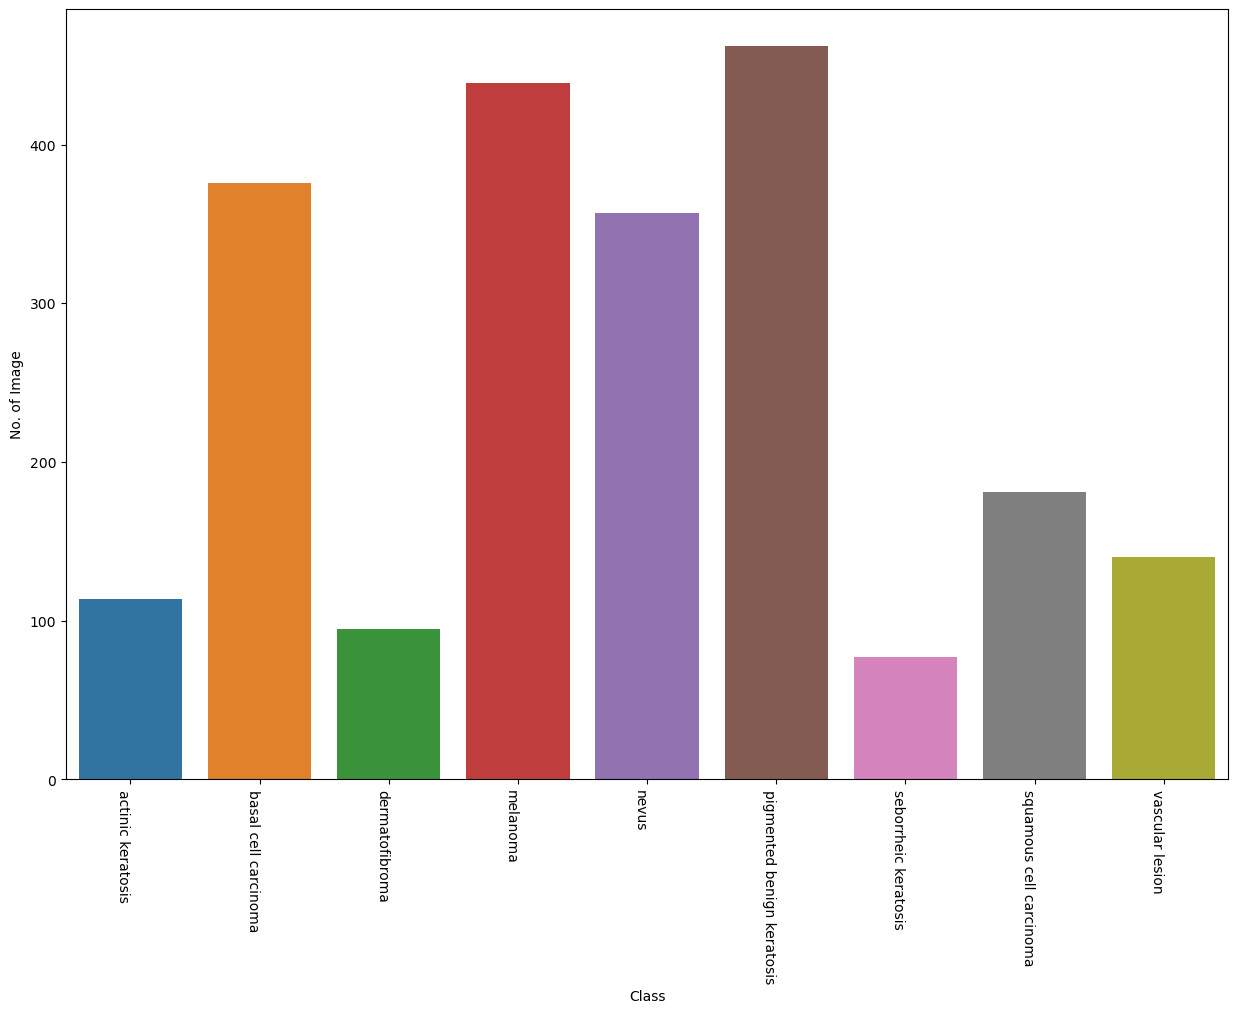

In [177]:
#Plot the count per class
import seaborn as sns
plt.figure(figsize=(15, 10))
plt.xticks(rotation=-90, ha='right')
#fig.set_xticklabels("Clas", rotation=45, ha='right')
sns.barplot(x="Class", y="No. of Image",  data=df,
            label="Class")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [178]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [179]:
### Your code goes here
#tf.keras.layers.Rescaling(scale, offset=0.0, **kwargs)
#normalization_layer  = tf.keras.layers.experimental.preprocessing.Rescaling(scale =1./255., offset=0.0)

In [180]:
# model
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [181]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [182]:
# View the summary of all layers
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_14 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_27 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_29 (Conv2D)          (None, 45, 45, 64)       

### Train the model

In [183]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 138s 511ms/step - loss: 2.0492 - accuracy: 0.2461 - val_loss: 2.0680 - val_accuracy: 0.3266
Epoch 2/20
56/56 [==============================] - 16s 288ms/step - loss: 1.7076 - accuracy: 0.4157 - val_loss: 1.5560 - val_accuracy: 0.4743
Epoch 3/20
56/56 [==============================] - 18s 330ms/step - loss: 1.4667 - accuracy: 0.4883 - val_loss: 1.4559 - val_accuracy: 0.5101
Epoch 4/20
56/56 [==============================] - 19s 331ms/step - loss: 1.3860 - accuracy: 0.5190 - val_loss: 1.3665 - val_accuracy: 0.5503
Epoch 5/20
56/56 [==============================] - 19s 332ms/step - loss: 1.2653 - accuracy: 0.5497 - val_loss: 1.4254 - val_accuracy: 0.5459
Epoch 6/20
56/56 [==============================] - 19s 335ms/step - loss: 1.2351 - accuracy: 0.5737 - val_loss: 1.4002 - val_accuracy: 0.5235
Epoch 7/20
56/56 [==============================] - 19s 333ms/step - loss: 1.1517 - accuracy: 0.5932 - val_loss: 1.3326 - val_accuracy: 0.543

### Visualizing training results

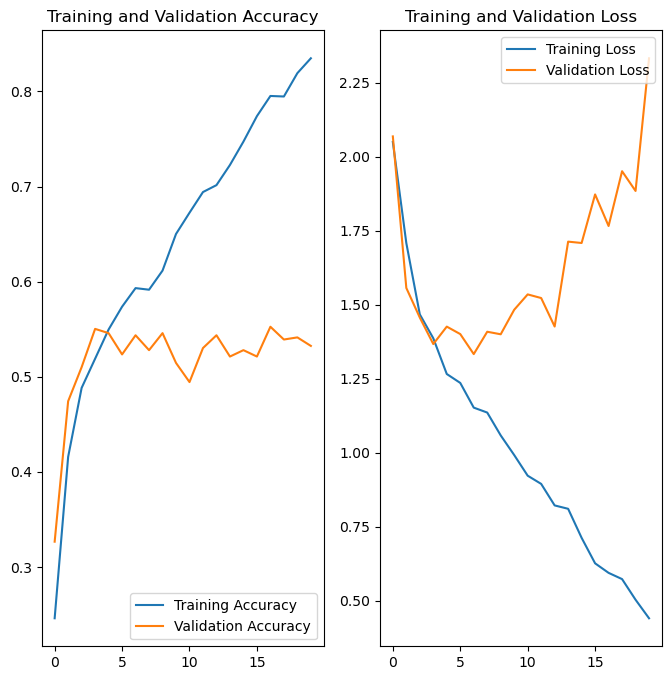

In [184]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### From above plot the Training Accuraacy is linearly increases as number of epoches increases, But the validation accuracy increased in beginning few epoches, then stayed around 55.  Also there is huge differene Training and valudation accuracy, which is an indication of model overfitting

In [191]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

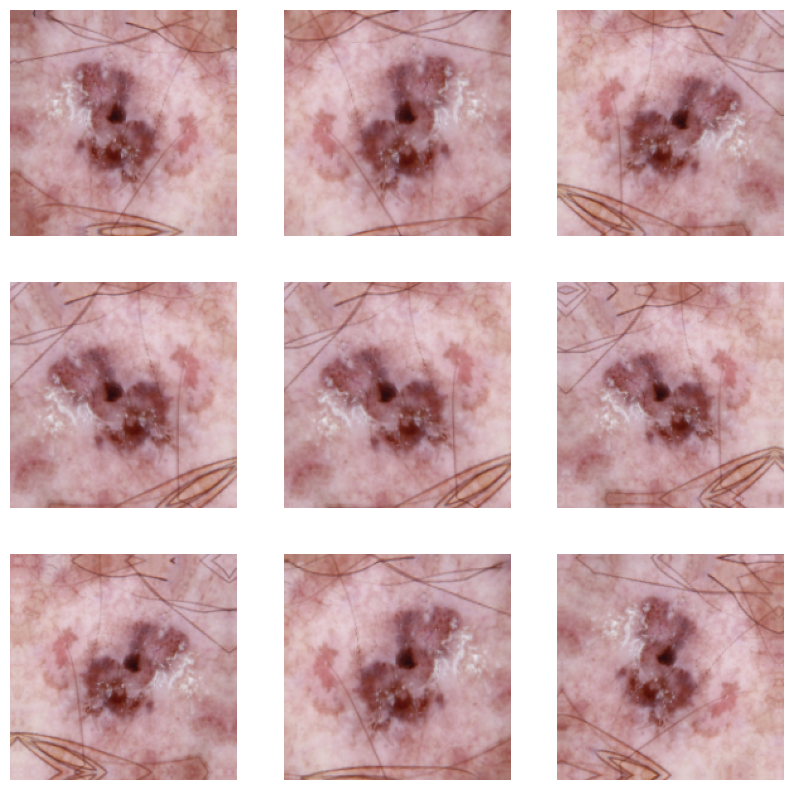

In [192]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [194]:
## You can use Dropout layer if there is an evidence of overfitting in your findings


model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])




### Compiling the model

In [195]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [196]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 30s 425ms/step - loss: 2.0208 - accuracy: 0.2673 - val_loss: 1.9280 - val_accuracy: 0.2729
Epoch 2/20
56/56 [==============================] - 24s 436ms/step - loss: 1.7599 - accuracy: 0.3722 - val_loss: 1.6137 - val_accuracy: 0.4407
Epoch 3/20
56/56 [==============================] - 25s 455ms/step - loss: 1.5794 - accuracy: 0.4470 - val_loss: 1.5216 - val_accuracy: 0.4765
Epoch 4/20
56/56 [==============================] - 25s 450ms/step - loss: 1.4954 - accuracy: 0.4760 - val_loss: 1.4892 - val_accuracy: 0.4832
Epoch 5/20
56/56 [==============================] - 25s 444ms/step - loss: 1.4157 - accuracy: 0.5084 - val_loss: 1.4820 - val_accuracy: 0.5056
Epoch 6/20
56/56 [==============================] - 25s 446ms/step - loss: 1.3828 - accuracy: 0.5106 - val_loss: 1.5765 - val_accuracy: 0.4340
Epoch 7/20
56/56 [==============================] - 25s 451ms/step - loss: 1.3522 - accuracy: 0.5128 - val_loss: 1.4664 - val_accuracy: 0.5235

### Visualizing the results

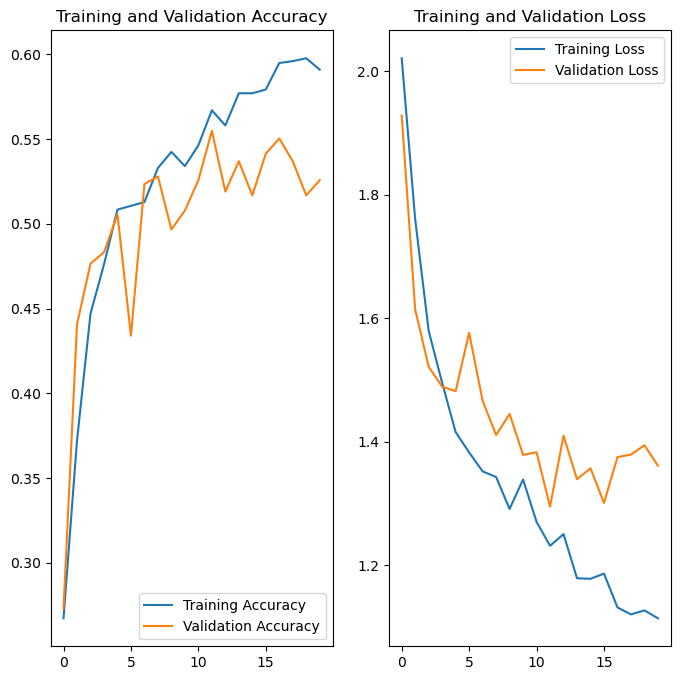

In [197]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### From the above plot it shows that traing and valicdation accuracy are close and increasing linearl increasing when as number of epoches goes up. This shows that model has overcome the overfitting.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [198]:
## Your code goes here.
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [199]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

Path              Label
0     C:\Users\G50-70\Downloads\CaseStudys\CNN_assig...  actinic keratosis
1     C:\Users\G50-70\Downloads\CaseStudys\CNN_assig...  actinic keratosis
2     C:\Users\G50-70\Downloads\CaseStudys\CNN_assig...  actinic keratosis
3     C:\Users\G50-70\Downloads\CaseStudys\CNN_assig...  actinic keratosis
4     C:\Users\G50-70\Downloads\CaseStudys\CNN_assig...  actinic keratosis
...                                                 ...                ...
2234  C:\Users\G50-70\Downloads\CaseStudys\CNN_assig...    vascular lesion
2235  C:\Users\G50-70\Downloads\CaseStudys\CNN_assig...    vascular lesion
2236  C:\Users\G50-70\Downloads\CaseStudys\CNN_assig...    vascular lesion
2237  C:\Users\G50-70\Downloads\CaseStudys\CNN_assig...    vascular lesion
2238  C:\Users\G50-70\Downloads\CaseStudys\CNN_assig...    vascular lesion

[2239 rows x 2 columns]

Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


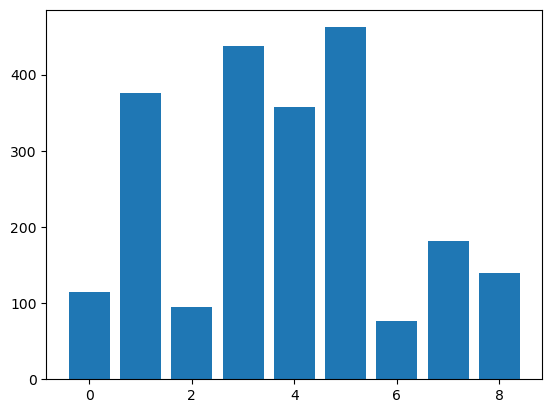

In [200]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here: 
##### From the above plot there is class imbalenace.  
#### - Which class has the least number of samples?
##### Class 6 has least number of samples. It has n=77 (3.439%) samples only
#### - Which classes dominate the data in terms proportionate number of samples?
##### Calss 6 dominates the data. It is 462 samples with 20.634% of total samples


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [185]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [209]:
path_to_training_dataset="C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train"
#pathlib.Path(


#path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    #p = Augmentor.Pipeline(pathlib.Path(path_to_training_dataset + str(i)))
    p = Augmentor.Pipeline("C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0


Initialised with 2239 image(s) found.
Output directory set to C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x6D8A0AE8B0>: 100%


Initialised with 2239 image(s) found.
Output directory set to C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x6D8B341670>: 100%|


Initialised with 2239 image(s) found.
Output directory set to C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x6DE698FA90>: 100%|


Initialised with 2239 image(s) found.
Output directory set to C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x6D8B347340>: 100%|


Initialised with 2239 image(s) found.
Output directory set to C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x6DB1D7C430>: 100%|


Initialised with 2239 image(s) found.
Output directory set to C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x6D8BAD95E0>: 100%|


Initialised with 2239 image(s) found.
Output directory set to C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train\output.

Processing <PIL.Image.Image image mode=RGB size=576x768 at 0x6DB1D542B0>: 100%|


Initialised with 2239 image(s) found.
Output directory set to C://Users//G50-70//Downloads//CaseStudys//CNN_assignment//Skin cancer ISIC The International Skin Imaging Collaboration//Train\output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x6D8BB6B640>: 100


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [240]:
image_count_train = len(list(data_dir_train_output.glob('*/*.jpg')))

print(image_count_train)

C:\Users\G50-70\Downloads\CaseStudys\CNN_assignment\Skin cancer ISIC The International Skin Imaging Collaboration\Train\output
4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [247]:
#path_list = [x for x in glob(os.path.join(data_dir_train_output, '*','output', '*.jpg'))]\
path_list = [x for x in glob(os.path.join(data_dir_train_output, '*', '*.jpg'))]
path_list

['C:\\Users\\G50-70\\Downloads\\CaseStudys\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025780.jpg_ec14b5d6-4c71-4383-946a-44c3648ff777.jpg',
 'C:\\Users\\G50-70\\Downloads\\CaseStudys\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025803.jpg_009a0ee6-c034-4d4e-bf48-161188166e25.jpg',
 'C:\\Users\\G50-70\\Downloads\\CaseStudys\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025825.jpg_05a17e71-b47f-40be-8989-f5694fda5a00.jpg',
 'C:\\Users\\G50-70\\Downloads\\CaseStudys\\CNN_assignment\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\output\\actinic keratosis\\actinic keratosis_original_ISIC_0025825.jpg_2492749e-49ca-4ea7-b26b-109913a9c678.jpg',
 'C:\\Users\\G50-70\\Dow

In [259]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train_output, '*', '*.jpg'))]
#path_list =         [x for x in glob(os.path.join(data_dir_train_output, '*', '*.jpg'))]
lesion_list_new

['output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',
 'output',

In [243]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

NameError: name 'path_list_new' is not defined

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [ ]:
data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create a validation dataset

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

#### **Todo:** Create your model (make sure to include normalization)

In [ ]:
## your code goes here

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [ ]:
## your code goes here

#### **Todo:**  Train your model

In [ ]:
epochs = 30
## Your code goes here, use 50 epochs.
history = # your model fit code

#### **Todo:**  Visualize the model results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

